### RD900 region analysis for multiple species

links 

* https://www.ncbi.nlm.nih.gov/nuccore/LT708304.1?report=graph
* https://www.patricbrc.org/view/Feature/PATRIC.233413.5.NC_002945.CDS.1412196.1413986.rev#view_tab=compareRegionViewer
* https://pypi.org/project/dna_features_viewer/0.1.1/

In [1]:
import os, glob, subprocess
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt

In [4]:
samples=pd.read_csv('genomes_data.csv')
#samples

In [5]:
rec = list(SeqIO.parse(open('RD900MAF.gb'), "genbank"))[0]

def get_gene_features(rec):
    from copy import copy
    new = copy(rec)
    new.features = []
    for f in rec.features:
        #print (f.qualifiers)
        x = f.__dict__
        q = f.qualifiers        
        if x['type'] == 'gene':
            if 'gene' in q:
                q['source'] = q['gene']
            else:
                q['source'] = q['locus_tag']
            new.features.append(f)           
    return new

def add_feature(rec, name, start, end, strand, clr='orange'):
    rec.features.append(SeqFeature(FeatureLocation(start, end), type="gene", strand=strand, qualifiers={'source':name,'color':clr}))
    
new=get_gene_features(rec) 
#add_feature(new, 'rd900', 3100, 6380, -1)
#add_feature(new, 'kinase', 2280, 3080, -1, 'green')

GFF.write([new], open('new.gff','w'))

In [34]:
f=new.features[0]
print (f)

type: gene
location: [<0:415](+)
qualifiers:
    Key: locus_tag, Value: ['BQ2027_MB1295']
    Key: source, Value: ['BQ2027_MB1295']



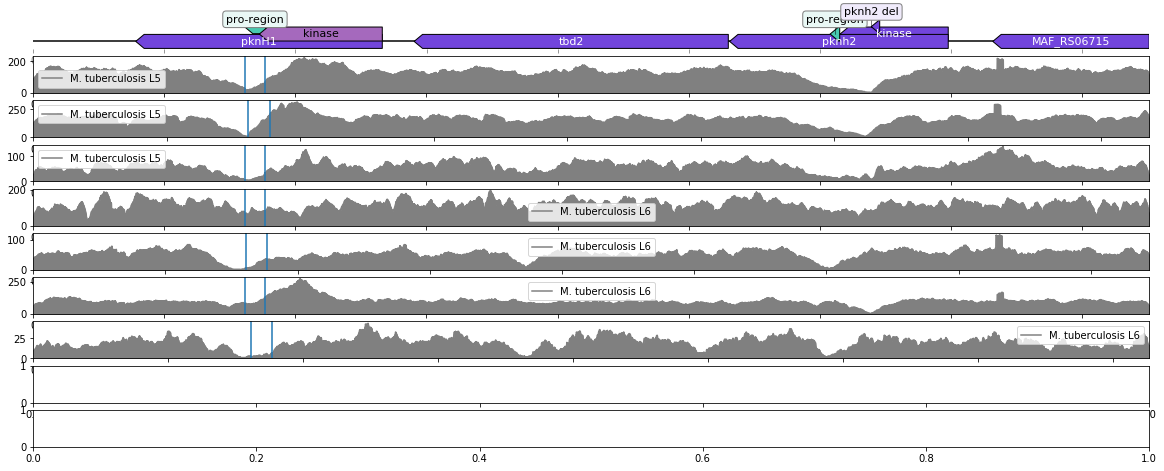

In [9]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

rec = list(GFF.parse('RD900MAF.gff'))[0]
graphic_record = BiopythonTranslator().translate_record(rec)
fig,axs=plt.subplots(10,1,figsize=(20,8))

ax, levels = graphic_record.plot(ax=axs[0])#,annotate_inline=True)
#ax, _ = graphic_record.plot(ax=axs[1], with_ruler=False)

path = '/home/elenam/read_data'
i=1
regions=[1612,1772]
for x,r in samples[16:23].iterrows():
    l=r.LINEAGE
    f='{p}/{n}.coverage'.format(p=path,n=r.ACCESSION)
    df = pd.read_csv(f,sep='\t',names=['id','pos','coverage'])
    bins=range(0,max(df.coverage),int(max(df.coverage)/10))
    df['binned']=np.searchsorted(bins, df.coverage.values)
    df.plot(y='coverage',ax=axs[i],kind='area',color='gray')
    #axs[i].set_xlim([0, 8000])
    axs[i].legend([l])
    for pos in regions:
        axs[i].axvline(x=pos)
    i+=1

In [63]:
#path = '/home/elenam/read_data'
path = '.'
#names = samples[samples.PAIRED=='yes'].ACCESSION
names = ['SRR650219']
for name in names:
    #cmd = 'bwa mem -t 6 RD900MAF.fa  {p}/{n}_1.fastq.gz {p}/{n}_2.fastq.gz | samtools view -b -F 4 > aligned/{n}.bam'.format(p=path,n=name)
    cmd = 'bowtie2 -fr -x RD900MAF -q -1 {p}/{n}_1.fastq.gz -2 {p}/{n}_2.fastq.gz --very-sensitive | samtools view -b -F 4 > aligned/{n}_bowtie.bam'.format(p=path,n=name)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #cmd='samtools sort aligned/{n}.bam > aligned/{n}.sorted.bam'.format(n=name)
    cmd='samtools sort aligned/{n}_bowtie.bam > aligned/{n}.bowtie.sorted.bam'.format(n=name)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #cmd = 'samtools depth {n}.sorted.bam > aligned/{n}.coverage'.format(n=name)
    #print (cmd)
    #subprocess.check_output(cmd,shell=True)

bowtie2 -fr -x RD900MAF -q -1 ./SRR650219_1.fastq.gz -2 ./SRR650219_2.fastq.gz --very-sensitive | samtools view -b -F 4 > aligned/SRR650219_bowtie.bam
samtools sort aligned/SRR650219_bowtie.bam > aligned/SRR650219.bowtie.sorted.bam


## use spades to assemble 

In [7]:
def spades(name):
    path='../assembly'        
    files = sorted(glob.glob(name+'*.gz'))
    out = '../assembly/%s' %name
    cmd = 'spades -t 12 --pe1-1 %s --pe1-2 %s --careful -o %s --only-assembler --trusted-contigs ../Mbovis_AF212297.fa' \
        %(files[0],files[1],out)
    print (cmd)
    #if not os.path.exists(out): 
    #    subprocess.check_output(cmd, shell=True)
    return

spades('SRR650219')

spades -t 12 --pe1-1 SRR650219_1.fastq.gz --pe1-2 SRR650219_2.fastq.gz --careful -o ../assembly/SRR650219 --only-assembler --trusted-contigs ../Mbovis_AF212297.fa


## annotate

In [9]:
n='SRR650219'
cmd = 'prokka --outdir ../annotation/{n} ../assembly/{n}/scaffolds.fasta --prefix {n}'.format(n=n)
print (cmd)

prokka --outdir ../annotation/SRR650219 ../assembly/SRR650219/scaffolds.fasta --prefix SRR650219


In [10]:
def read_nucmer_coords(cfile,min_length=0):
    cols=['S1','E1','S2','E2','LEN 1','LEN 2','IDENT','TAG1','TAG2']
    a=pd.read_csv(cfile,sep='[\s|]+',skiprows=5,names=cols,engine='python')
    a=a.sort_values('S1',ascending=True)
    a=a[a['LEN 1']>min_length]
    return a

cmd = 'nucmer --coords -p nucmer RD900.fa ../assembly/{n}/scaffolds.fasta'.format(n=n)
print (cmd)

nucmer --coords -p nucmer RD900.fa ../assembly/SRR650219/scaffolds.fasta


In [12]:
nc=read_nucmer_coords('nucmer.coords')
nc

,S1,E1,S2,E2,LEN 1,LEN 2,IDENT,TAG1,TAG2
0,1,9316,67015,76329,9316,9315,99.92,RD900,NODE_2_length_447585_cov_7.247823
